In [459]:
from abc import ABC, abstractmethod
import random
import numpy as np
import copy
import matplotlib.pyplot as plt

In [18]:
class DiscreteEnvironment(ABC):
    
    @abstractmethod
    def step(self,action):
        pass
    
    @abstractmethod
    def reset(self):
        pass
    
class DiscreteAgent(ABC):
    @abstractmethod
    def __init__(self,env):
        pass
    
    @abstractmethod
    def update(self):
        pass
    
    @abstractmethod
    def get_action(self,state):
        pass

In [473]:
class GridWorld(DiscreteEnvironment):
    def __init__(self,r,c):
        self.maxrow = r
        self.maxcol = c
        self.tot_act = 4
        self.actions = [0,1,2,3]
        self.vi_list = []
        self.pi_list = []
        self.reset()  
        
    def foul_state(self,row,col):
        if row < 0 or row >= self.maxrow or col < 0 or col >= self.maxcol:
            return 1
        return 0
    
    def step(self,action):
        row_copy = self.navigate_row
        col_copy = self.navigate_col
        
        if self.navigate_row == self.goal_row and self.navigate_col == self.goal_col:
            reward = 10
            done = True
            state = (self.navigate_row,self.navigate_col)
        else:
            if action == 0:
                self.navigate_row -= 1
            elif action == 1:
                self.navigate_row += 1
            elif action == 2:
                self.navigate_col -= 1
            elif action == 3:
                self.navigate_col += 1

            if self.foul_state(self.navigate_row,self.navigate_col): 
                reward = -10
                done = True
                state = (row_copy,col_copy)
                #print(state)
            elif self.navigate_row == self.goal_row and self.navigate_col == self.goal_col:
                reward = 10
                done = True
                state = (self.navigate_row,self.navigate_col)
            else: 
                reward = 0
                done = False
                state = (self.navigate_row,self.navigate_col)
        
        return state,reward,done
    
    '''
    Used for dynamic programming methods where the start state is selected iteratively
    '''
    def set_start_state(self,state):
        self.navigate_row = state[0]
        self.navigate_col = state[1]
        
    '''
    Initialize random start and goal state
    '''
    def reset(self):
        
        #self.start_row = 0#random.randint(0,self.maxrow-1)
        #self.start_col = 0#random.randint(0,self.maxcol-1)
        self.goal_row = 7#random.randint(0,self.maxrow-1)
        self.goal_col = 7#random.randint(0,self.maxcol-1)
        #self.navigate_row = self.start_row
        #self.navigate_col = self.start_col 
    
    '''
    Under construction
    '''
    def vi_test(self,Q):
        N = 10
        return_val = 0
        while N:
            start_row = 0#random.randint(0,self.maxrow-1)
            start_col = 0#random.randint(0,self.maxcol-1)
            tot_iter = 20
            while tot_iter:
                state = (start_row,start_col)
                self.set_start_state(state)
                action = np.argmax(Q[state])
                new_state,reward,done = self.step(action)
                return_val += (reward + 0.9 * np.max(Q[new_state]))/N
                if new_state[0] == self.goal_row and new_state[1] == self.goal_col:
                    break
                tot_iter -= 1
                start_row = new_state[0]
                state_col = new_state[1]
            N-=1
        self.vi_list.append(return_val)

In [474]:
class ValueIteration(DiscreteAgent):
    def __init__(self,env):
        self.env = env
        self.gamma = 0.9
        self.Q = np.zeros((env.maxrow,env.maxcol,env.tot_act))
        self.V = np.zeros((env.maxrow,env.maxcol))
        
    def update(self):
        for row in range(len(self.V)):
            for col in range(len(self.V[row])):
                state=(row,col)
                for action in env.actions:
                    env.set_start_state(state)
                    new_state,reward,done = env.step(action)
                    #print(reward)
                    self.Q[state][action] = reward + self.gamma * self.V[new_state]
                self.V[state] = np.max(self.Q[state])
        
        self.env.vi_test(self.Q)
    
    def get_action(self):
        pass

In [455]:
class PolicyIteration(DiscreteAgent):
    def __init__(self,env):
        self.env = env
        self.gamma = 0.9
        self.Q = np.zeros((env.maxrow,env.maxcol,env.tot_act))
        self.V = np.zeros((env.maxrow,env.maxcol))
        self.policy = np.random.randint(env.tot_act,size=(env.maxrow,env.maxcol))
        self.policy_stable = False
    
    def update(self):
        while not self.policy_stable:
            self.policy_evaluation()
            self.policy_improvement()
    
    def policy_evaluation(self):
        eps = 1e-10
        while True:
            delta = 0
            for row in range(len(self.V)):
                for col in range(len(self.V[row])):
                    state=(row,col)
                    v = self.V[state]
                    env.set_start_state(state)
                    action = self.policy[state]
                    new_state,reward,done = env.step(action)
                    self.Q[state][action] = reward + self.gamma * self.V[new_state]
                    self.V[state] = self.Q[state][action]
                    delta = max(delta,np.abs(v-self.V[state]))
                    
            if delta < eps:
                break
            
    def policy_improvement(self):
        self.policy_stable = True
        for row in range(len(self.V)):
            for col in range(len(self.V[row])):
                state=(row,col)
                v = self.V[state]
                for action in env.actions:
                    env.set_start_state(state)
                    new_state,reward,done = env.step(action)
                    self.Q[state][action] = reward + self.gamma * self.V[new_state]
                #if v != np.max(self.Q[state]):
                self.V[state] = np.max(self.Q[state])
                if np.argmax(self.Q[state]) != self.policy[state]:
                    self.policy[state] = np.argmax(self.Q[state])
                    self.policy_stable = False
                    
    
    def get_action(self):
        pass

## Value Iteration

In [475]:
env = GridWorld(8,8)
agent  = ValueIteration(env)


sweep_no,max_sweeps = 0,200
while sweep_no < max_sweeps:
    #print('new_update')
    agent.update()
    sweep_no+=1

In [476]:
agent.V

array([[25.41865821, 28.24295358, 31.38105954, 34.86784394, 38.74204883,
        43.04672093, 47.82968993, 53.14409993],
       [28.24295358, 31.38105954, 34.86784394, 38.74204883, 43.04672093,
        47.82968993, 53.14409993, 59.04899993],
       [31.38105954, 34.86784394, 38.74204883, 43.04672093, 47.82968993,
        53.14409993, 59.04899993, 65.60999993],
       [34.86784394, 38.74204883, 43.04672093, 47.82968993, 53.14409993,
        59.04899993, 65.60999993, 72.89999993],
       [38.74204883, 43.04672093, 47.82968993, 53.14409993, 59.04899993,
        65.60999993, 72.89999993, 80.99999993],
       [43.04672093, 47.82968993, 53.14409993, 59.04899993, 65.60999993,
        72.89999993, 80.99999993, 89.99999993],
       [47.82968993, 53.14409993, 59.04899993, 65.60999993, 72.89999993,
        80.99999993, 89.99999993, 99.99999993],
       [53.14409993, 59.04899993, 65.60999993, 72.89999993, 80.99999993,
        89.99999993, 99.99999993, 99.99999993]])

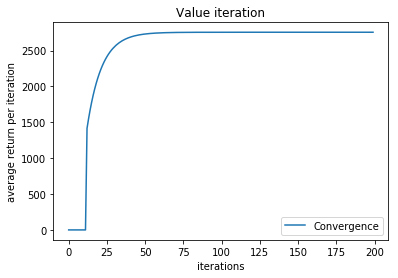

In [478]:
iteration = list(range(0,max_sweeps))
plt.plot(iteration,env.vi_list,label='Convergence')
#plt.plot(episodeList,valerrList,label = 'Training Error')
plt.xlabel("iterations")
plt.ylabel("average return per iteration")
plt.title("Value iteration")
plt.legend()
plt.show()

## Poilcy Iteration

In [439]:
env = GridWorld(8,8)
print('start = ',env.start_row,' ',env.start_col)
print('goal = ',env.goal_row,' ',env.goal_col)
agent  = PolicyIteration(env)
#print(agent.V)
#print(agent.Q)
#print(agent.policy)
agent.update()

start =  0   0
goal =  7   7


In [441]:
print(agent.policy)
print(agent.V)

[[1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [3 3 3 3 3 3 3 0]]
[[ 25.41865828  28.24295365  31.38105961  34.86784401  38.7420489
   43.046721    47.82969     53.1441    ]
 [ 28.24295365  31.38105961  34.86784401  38.7420489   43.046721
   47.82969     53.1441      59.049     ]
 [ 31.38105961  34.86784401  38.7420489   43.046721    47.82969
   53.1441      59.049       65.61      ]
 [ 34.86784401  38.7420489   43.046721    47.82969     53.1441
   59.049       65.61        72.9       ]
 [ 38.7420489   43.046721    47.82969     53.1441      59.049
   65.61        72.9         81.        ]
 [ 43.046721    47.82969     53.1441      59.049       65.61
   72.9         81.          90.        ]
 [ 47.82969     53.1441      59.049       65.61        72.9
   81.          90.         100.        ]
 [ 53.1441      59.049       65.61        72.9         81.
   90.         100.         100.        ]]
